## TOC:
* [1. Setup](#setup)
* [2. Mean Face Diff](#meandiff)
* [3. Mean Frame Diff](#framediff)
* [4. Mean Texture Diff](#texturediff)
* [5. 4dface Output](#4dface)

# 1. Setup <a class="anchor" id="setup"></a>

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import menpo
import menpo.io as mio
import menpo3d
from menpo.shape import mean_pointcloud, PointCloud, TriMesh
from menpofit.modelinstance import OrthoPDM, PCAModel
from menpowidgets import visualize_images
from menpo.io import export_image, export_landmark_file
from menpowidgets import visualize_appearance_model

In [2]:
!mkdir /data1/famface01/analysis/misc/100_stimuli 2> /dev/null
!mkdir /data1/famface01/analysis/misc/120_features 2> /dev/null

In [3]:
odir  = "/data1/famface01/analysis/misc/100_stimuli"
odir2 = "/data1/famface01/analysis/misc/120_features"

In [4]:
unfam_df = pd.read_csv("/data1/famface01/analysis/encoding/12_Features/unfam_final_frame_df.csv")
unfam_df.head()

,Unnamed: 0,vnum,vid,frame,category,fpath
0,0,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,3,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
1,1,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,9,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
2,2,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,15,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
3,3,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,21,unfam,/data1/famface01/data/stimuli/vids/eight_frame...
4,4,14,Ahmed_Chalabi_U000_vid06_clip05_2secs,27,unfam,/data1/famface01/data/stimuli/vids/eight_frame...


In [5]:
ref_vids = sorted(np.unique(unfam_df.vid))

In [6]:
vidnames = sorted(os.listdir("/data1/famface01/data/stimuli/vids/eight_frames/three_dee"))
print len(vidnames)
vidnames = [ v for v in vidnames if v in ref_vids ]
print len(vidnames)

1248
864


# 2. Mean Face Difference <a class="anchor" id="meandiff"></a>

This will get two measures useful for the prototype model.

## Load

In [ ]:
meshes = []
basedir = "/data1/famface01/data/stimuli/vids/eight_frames/three_dee"
for v in tqdm(vidnames):
    f = os.path.join(basedir, v, "%s_merged_shape_fr8.obj" % v)
    mesh = menpo3d.io.import_mesh(f)
    meshes.append(mesh)

In [ ]:
pointclouds = []
for m in tqdm(meshes):
    pc = PointCloud(m.points)
    pointclouds.append(pc)

## Simple Measure

I take the euclidean distance of each face shape with the mean face shape.

In [ ]:
mean_pc = mean_pointcloud(pointclouds)

In [ ]:
trilist = meshes[0].trilist
menpo3d.io.export_mesh(TriMesh(mean_pc.points, trilist), os.path.join(odir, "unfam_mean_face.obj"), overwrite=True)

In [ ]:
mean_diffs = np.array([ mean_pc.distance_to(pc).diagonal().mean() for pc in tqdm(pointclouds) ])

## PCA Measure

Since the PCA model removes the mean, I can take the root mean squares.

In [ ]:
pca = OrthoPDM(pointclouds)

In [ ]:
pca.model.eigenvalues_cumulative_ratio()[:50]

In [ ]:
trilist = meshes[0].trilist
menpo3d.io.export_mesh(TriMesh(pca.model.mean().points, trilist), os.path.join(odir, "unfam_mean_pcaface.obj"), overwrite=True)

In [ ]:
# Take top 50 comps diff
shape_dat = np.array([ pc.as_vector() for pc in pointclouds ])
pca_comps = pca.model.project_vectors(shape_dat)
mean_pcadiffs = np.sqrt((pca_comps[:,:50]**2).mean(axis=1))

## Compare

They are highly related.

In [ ]:
np.corrcoef(mean_diffs, mean_pcadiffs)

# 3. Mean Frame Difference <a class="anchor" id="framediff"></a>

Dunno what to do.

## Load

In [ ]:
frame_meshes = []
basedir = "/data1/famface01/data/stimuli/vids/eight_frames/three_dee"
for v in tqdm(vidnames):
    for i in range(8):
        f = os.path.join(basedir, v, "%s_shape_fr%i.obj" % (v, i+1))
        mesh = menpo3d.io.import_mesh(f)
        frame_meshes.append(mesh)

In [ ]:
frame_pcs = []
for m in tqdm(frame_meshes):
    pc = PointCloud(m.points)
    frame_pcs.append(pc)

## Simple Measure

In [ ]:
# Loop through every 8 frames (1 video)
# and get the mean framewise displacement
mean_frame_diffs = []
for istart in tqdm(range(0, len(frame_meshes), 8)):
    ds = []
    for i in range(7):
        d = frame_pcs[istart+i].distance_to(frame_pcs[istart+i+1]).diagonal().mean()
        ds.append(d)
    mean_frame_diffs.append(np.mean(ds))
mean_frame_diffs = np.array(mean_frame_diffs)

In [ ]:
np.corrcoef(np.vstack((mean_frame_diffs, mean_diffs, mean_pcadiffs)))

## PCA

In [ ]:
fpca = OrthoPDM(frame_pcs)

In [ ]:
nc = np.sum(fpca.model.eigenvalues_cumulative_ratio() < pca.model.eigenvalues_cumulative_ratio()[50]) # so 63 comps
print nc

In [ ]:
# Take top 50 comps diff
shape_dat = np.array([ pc.as_vector() for pc in frame_pcs ])
pca_comps = pca.model.project_vectors(shape_dat)
pca_comps.shape

In [ ]:
mean_frame_pcadiffs = []
for istart in tqdm(range(0, len(frame_meshes), 8)):
    ds = []
    for i in range(7):
        d2 = (pca_comps[istart+i,:nc] - pca_comps[istart+i+1,:nc])**2
        d  = np.sqrt(d2.mean())
        ds.append(d)
    mean_frame_pcadiffs.append(np.mean(ds))
mean_frame_pcadiffs = np.array(mean_frame_pcadiffs)

In [ ]:
np.corrcoef(mean_frame_pcadiffs, mean_frame_diffs)

# 4. Mean Texture Diff <a class="anchor" id="texturediff"></a>

## Load

In [ ]:
basedir = "/data1/famface01/data/stimuli/vids/eight_frames/three_dee"
timgs = []
for v in tqdm(vidnames):
    img = mio.import_image(os.path.join(basedir, v, "%s_merged_isomap_fr8.png" % v))
    timgs.append(img)

In [ ]:
visualize_images(timgs)

In [ ]:
# See what pixels are missing (make a group mask)
concat_masks = np.array([ timg.mask.pixels.squeeze() for timg in timgs ])
group_prob = concat_masks.mean(axis=0)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(group_prob.flatten(), 20)

In [ ]:
tmp = menpo.image.Image(group_prob)
tmp.view(cmap_name='Reds')

In [ ]:
tmp = menpo.image.Image((group_prob>0.8)*1)
tmp.view(cmap_name='Reds')

In [ ]:
# Apply a group mask to make everything consistent
group_mask = (group_prob > 0.8) * 1

timgs2 = []
for img in tqdm(timgs):
    timgs2.append(img.as_unmasked().as_masked(group_mask))

## PCA Measure

In [ ]:
texture_pca = PCAModel(timgs2, verbose=True)

In [ ]:
visualize_appearance_model(texture_pca)

In [ ]:
texture_pca.mean().view()

In [ ]:
export_image(texture_pca.mean(), os.path.join(odir, "unfam_mean_pcaface_isoform.png"), overwrite=True)

In [ ]:
# Let's go with 98% variance or first 200 components
print np.sum(texture_pca.eigenvalues_cumulative_ratio() < 0.95)
print np.sum(texture_pca.eigenvalues_cumulative_ratio() < 0.97)
print np.sum(texture_pca.eigenvalues_cumulative_ratio() < 0.98)
print np.sum(texture_pca.eigenvalues_cumulative_ratio() < 0.99)

In [ ]:
# Take top 200 comps diff
texture_dat = np.array([ img.as_vector() for img in timgs2 ])
texture_comps = texture_pca.project_vectors(texture_dat)
texture_pcadiffs = np.sqrt((texture_comps[:,:200]**2).mean(axis=1))

In [ ]:
np.corrcoef(texture_pcadiffs, mean_pcadiffs)

# 4.5. Mean Framewise Texture

The images here I think are very noisy and may not be worth the framewise analysis.

## Load

In [7]:
basedir = "/data1/famface01/data/stimuli/vids/eight_frames/three_dee"
timgs = []
for v in tqdm(vidnames):
    for i in range(8):
        f = os.path.join(basedir, v, "%s_isomap_fr%i.png" % (v, i+1))
        img = mio.import_image(f)
        img = img.rescale_to_diagonal(200)
        timgs.append(img)

100%|██████████| 864/864 [02:38<00:00,  5.35it/s]


In [ ]:
visualize_images(timgs)

In [8]:
# See what pixels are missing (make a group mask)
concat_masks = np.array([ timg.mask.pixels.squeeze() for timg in timgs ])
group_prob = concat_masks.mean(axis=0)

In [9]:
# Apply a group mask to make everything consistent
group_mask = (group_prob > 0.5) * 1

timgs2 = []
for img in tqdm(timgs):
    timgs2.append(img.as_unmasked().as_masked(group_mask))

100%|██████████| 6912/6912 [00:01<00:00, 3957.77it/s]


## PCA Measure

In [10]:
texture_pca = PCAModel(timgs2, verbose=True, max_n_components=500) # adjust this max....

Allocated data matrix of size 2.40 GB (6912 samples)
Building data matrix: [==========] 100% (6912/6912) - done.                     

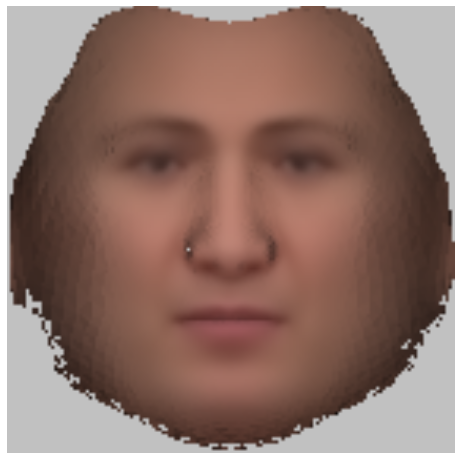

In [11]:
visualize_appearance_model(texture_pca)

In [ ]:
texture_pca.mean().view()

In [ ]:
#export_image(texture_pca.mean(), os.path.join(odir, "unfam_mean_pcaface_isoform.png"), overwrite=True)

In [ ]:
# viz it
print np.sum(texture_pca.eigenvalues_cumulative_ratio() < 0.95)
print np.sum(texture_pca.eigenvalues_cumulative_ratio() < 0.97)
print np.sum(texture_pca.eigenvalues_cumulative_ratio() < 0.98)
print np.sum(texture_pca.eigenvalues_cumulative_ratio() < 0.99)

In [12]:
tdat = np.array([ timg.as_vector() for timg in timgs2 ])

In [15]:
texture_scores = texture_pca.project_vectors(tdat)

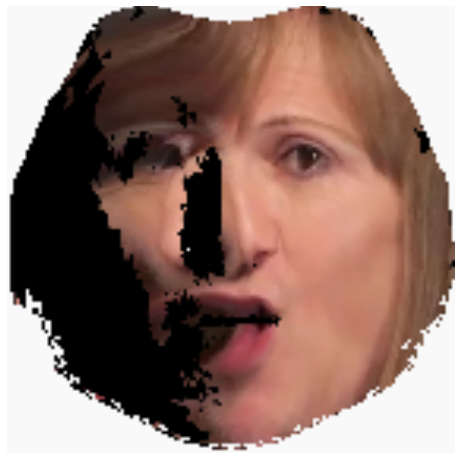

In [31]:
visualize_images(np.array(timgs2)[np.argsort(texture_scores[:,1])])

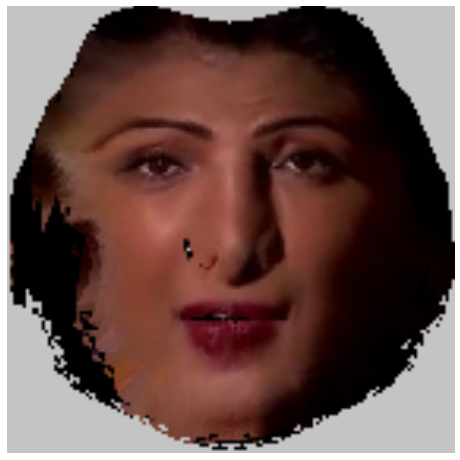

In [30]:
visualize_images(np.array(timgs2)[np.argsort(texture_scores[:,0][::-1])])

# 5. 4dface Model Outputs <a class="anchor" id="4dface"></a>

## Load

We will also calculate the mean shape and blend values.

In [ ]:
basedir = "/data1/famface01/data/stimuli/vids/eight_frames/three_dee"

In [ ]:
blend_mats = []
shape_mats = []
pose_mats  = []

for v in tqdm(vidnames):
    blend = np.loadtxt(os.path.join(basedir, v, "%s_coefs_blend.txt" % v))
    shape = np.loadtxt(os.path.join(basedir, v, "%s_coefs_shape.txt" % v))
    pose  = np.loadtxt(os.path.join(basedir, v, "%s_pose.txt" % v))
    blend_mats.append(blend)
    shape_mats.append(shape)
    pose_mats.append(pose)

blend_mats = np.array(blend_mats)
shape_mats = np.array(shape_mats)
pose_mats  = np.array(pose_mats)

print blend_mats.shape
print shape_mats.shape
print pose_mats.shape

In [ ]:
mean_shape_mats = shape_mats.mean(axis=1)
mean_blend_mats = blend_mats.mean(axis=1)
mean_pose_mats  = pose_mats.mean(axis=1)
print mean_shape_mats.shape
print mean_blend_mats.shape
print mean_pose_mats.shape

## Calculate Diff Measures

In [ ]:
mean_shape_diff = np.sqrt(np.mean(mean_shape_mats**2, axis=1))
mean_blend_diff = np.sqrt(np.mean(mean_blend_mats**2, axis=1))
mean_pose_diff  = np.sqrt(np.mean(mean_pose_mats**2, axis=1))

In [ ]:
np.corrcoef(np.vstack([mean_blend_diff, mean_shape_diff, mean_pose_diff, mean_diffs, mean_pcadiffs]))

## Calculate FrameDiff Measure

In [ ]:
mean_shape_framediff = []
mean_blend_framediff = []
mean_pose_framediff  = []

n = len(vidnames)
for i in tqdm(range(n)):
    ds1 = []; ds2 = []; ds3 = []
    for j in range(7):
        d1 = np.sqrt(np.sum((shape_mats[i,j,:] - shape_mats[i,j+1,:])**2))
        d2 = np.sqrt(np.sum((blend_mats[i,j,:] - blend_mats[i,j+1,:])**2))
        d3 = np.sqrt(np.sum((pose_mats[i,j,:] - pose_mats[i,j+1,:])**2))
        ds1.append(d1)
        ds2.append(d2)
        ds3.append(d3)
    mean_shape_framediff.append(np.mean(ds1))
    mean_blend_framediff.append(np.mean(ds2))
    mean_pose_framediff.append(np.mean(ds3))

mean_shape_framediff = np.array(mean_shape_framediff)
mean_blend_framediff = np.array(mean_blend_framediff)
mean_pose_framediff  = np.array(mean_pose_framediff)

In [ ]:
np.round(np.corrcoef(np.vstack([mean_diffs, mean_blend_diff, mean_shape_diff, mean_pose_diff, mean_frame_diffs, mean_shape_framediff, mean_blend_framediff])), 4)

# 7. Save

We should decide what have the different outputs to save. Okay so the following:

- Pose: mean pose and mean pose framewise
- Shape: mean diff and mean framewise
- Blend: mean blend and mean blend framewise
- Texture: mean texture and mean texture framewise

In [ ]:
d = {'vid': vidnames, 
     'pose': mean_pose_diff, 'framewise_pose': mean_pose_framediff, 
     'shape': mean_diffs, 'framewise_shape': mean_frame_diffs, 
     'expression': mean_blend_diff, 'framewise_expression': mean_blend_framediff, 
     'texture': texture_pcadiffs}
out_df = pd.DataFrame(d, columns=['vid', 'pose', 'framewise_pose', 'shape', 'framewise_shape', 
                                  'expression', 'framewise_expression', 'texture'])
out_df.head()

In [ ]:
out_df.to_csv(os.path.join(odir2, "df_meandiffs_4dface.csv"))

In [ ]:
d2 = {'vid': vidnames, 
      'pose': mean_pose_diff, 'framewise_pose': mean_pose_framediff, 
      'shape': mean_shape_diff, 'framewise_shape': mean_shape_framediff, 
      'expression': mean_blend_diff, 'framewise_expression': mean_blend_framediff, 
      'texture': texture_pcadiffs}
out_df2 = pd.DataFrame(d2, columns=['vid', 'pose', 'framewise_pose', 'shape', 'framewise_shape', 
                                  'expression', 'framewise_expression', 'texture'])
out_df2.to_csv(os.path.join(odir2, "df_meandiffs2_4dface.csv"))
out_df2.head()

In [ ]:
d3 = {'vid': vidnames, 
      'pose': mean_pose_diff, 'framewise_pose': mean_pose_framediff, 
      'shape': mean_pcadiffs, 'framewise_shape': mean_frame_pcadiffs, 
      'expression': mean_blend_diff, 'framewise_expression': mean_blend_framediff, 
      'texture': texture_pcadiffs}
out_df3 = pd.DataFrame(d3, columns=['vid', 'pose', 'framewise_pose', 'shape', 'framewise_shape', 
                                  'expression', 'framewise_expression', 'texture'])
out_df3.to_csv(os.path.join(odir2, "df_meandiffs3_4dface.csv"))
out_df3.head()